In [1]:
import os
import math
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

2024-04-07 04:17:31.959281: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 04:17:31.959406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 04:17:32.143812: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
NUM_CLASSES = 2
CLASSES = ['Control', 'Dementia']

IMAGE_SIZE = (128, 128)
EPOCHS = 100
LR = 1e-4
BATCH_SIZE = 32

In [3]:
def create_dataframe_from_directory(data_dir):
    filenames, labels = [], []
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)
        list = [os.path.join(folder_name, filename)
                for filename in os.listdir(folder_path)]
        filenames.extend(list)
        labels.extend([folder_name] * len(list))
    return pd.DataFrame({
        'filename': filenames,
        'label': labels
    })

df = create_dataframe_from_directory("/kaggle/input/Dataset")
df = df.replace(["Non_Demented"], "Control")
df = df.replace(["Very_Mild_Demented", "Mild_Demented", "Moderate_Demented"], "Dementia")

In [4]:
split = train_test_split(df, df["label"], test_size = 0.3)
train_df = split[0]
split2 = train_test_split(split[1], split[1]["label"], test_size = 0.66)
test_df = split2[0]
val_df = split2[1]

In [5]:
NUM_TRAINING_IMAGES = len(train_df.index)
NUM_VALIDATION_IMAGES = len(val_df.index)
NUM_TEST_IMAGES = len(test_df.index)

STEPS_PER_EPOCH = int(np.ceil(NUM_TRAINING_IMAGES / BATCH_SIZE))
VALIDATION_STEPS = int(np.ceil(NUM_VALIDATION_IMAGES / BATCH_SIZE))
TEST_STEPS = int(np.ceil(NUM_TEST_IMAGES / BATCH_SIZE))

print("Training images:", NUM_TRAINING_IMAGES)
train_label_counts = train_df['label'].value_counts().rename(
    index=dict(enumerate(CLASSES)))
print(", ".join([f"{label}: {count}" for label,
      count in train_label_counts.items()]))
print()

print("Validation images:", NUM_VALIDATION_IMAGES)
val_label_counts = val_df['label'].value_counts().rename(
    index=dict(enumerate(CLASSES)))
print(", ".join([f"{label}: {count}" for label,
      count in val_label_counts.items()]))
print()

print("Test images:", NUM_TEST_IMAGES)
test_label_counts = test_df['label'].value_counts().rename(
    index=dict(enumerate(CLASSES)))
print(", ".join([f"{label}: {count}" for label,
      count in test_label_counts.items()]))

Training images: 4480
Dementia: 2276, Control: 2204

Validation images: 1268
Control: 649, Dementia: 619

Test images: 652
Control: 347, Dementia: 305


In [6]:
data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_set = data_aug.flow_from_dataframe(
    train_df,
    directory="/kaggle/input/Dataset",
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 4480 validated image filenames belonging to 2 classes.


In [7]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

valid_set = data_gen.flow_from_dataframe(
    val_df,
    directory="/kaggle/input/Dataset",
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

test_set = data_gen.flow_from_dataframe(
    test_df,
    directory="/kaggle/input/Dataset",
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1268 validated image filenames belonging to 2 classes.
Found 652 validated image filenames belonging to 2 classes.


In [8]:
def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    # return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
    #                             CLASSES[correct_label] if not correct else ''), correct
    return "{} [{}]".format(CLASSES[label], CLASSES[correct_label] if not correct else '\u2713'), correct


def display_one(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2),
                  color='red' if red else 'black', fontdict={'verticalalignment': 'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch(batch, predictions=None):
    images, labels = batch

    labels = np.argmax(labels, axis=1)
    # print(labels)
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows

    # size and spacing
    FIGSIZE = 12.0
    SPACING = 0.1

    subplot = (rows, cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE, FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols, FIGSIZE))

    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows, cols)*40+3
        # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one(image, title, subplot,
                              not correct, titlesize=dynamic_titlesize)

    # layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [9]:
def display_history(history):
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    ax[0].plot(history.history['loss'], color='b', label="training_loss")
    ax[0].plot(history.history['val_loss'], color='r',
               label="validation_loss", axes=ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['accuracy'],
               color='b', label="training_accuracy")
    ax[1].plot(history.history['val_accuracy'],
               color='r', label="validation_accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()


def display_confusion_matrix(
        cm, classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

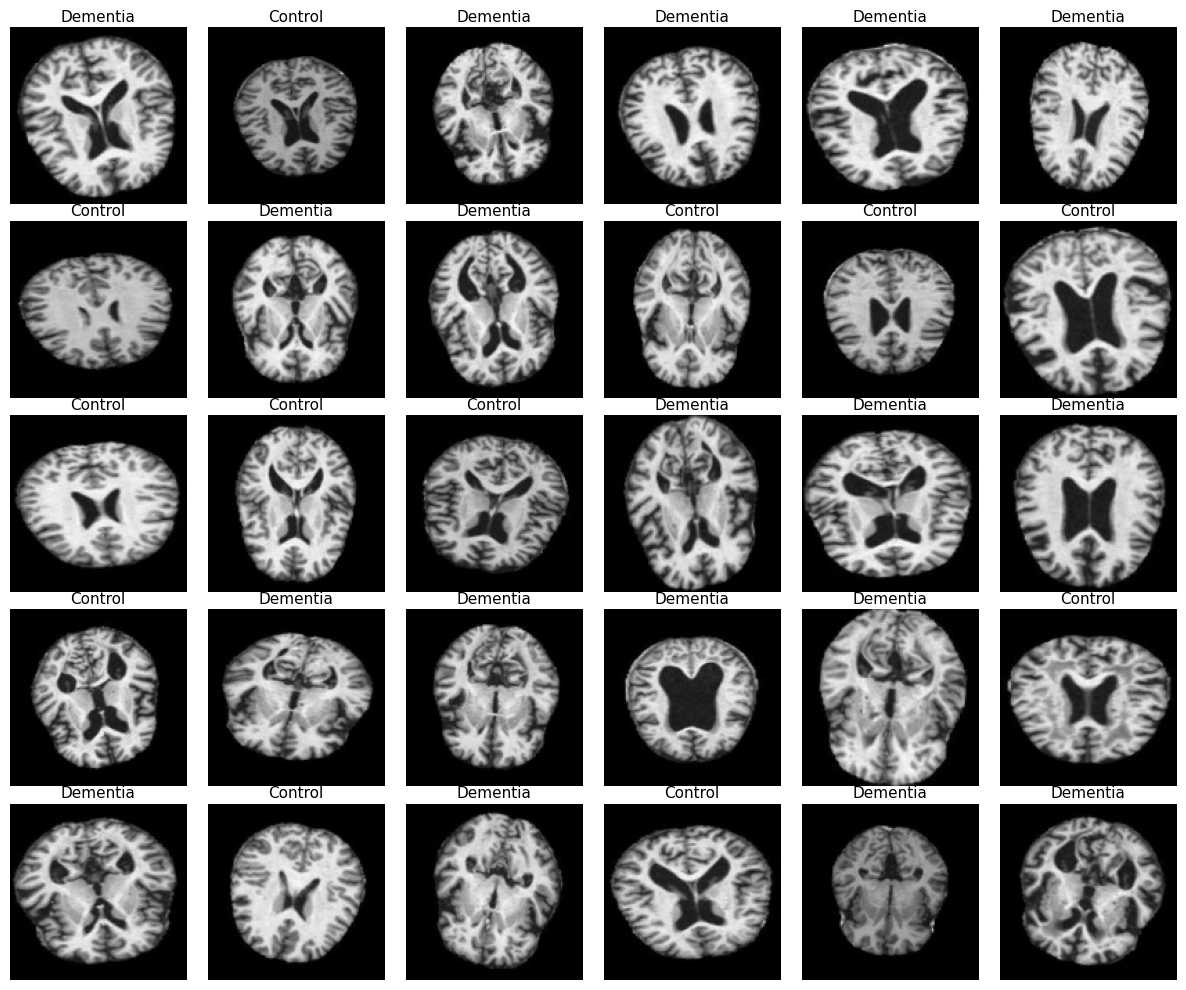

In [10]:
display_batch(next(iter(train_set)))

In [11]:
reduce_lr_val_acc = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.2,
    min_lr=1e-6,
)

reduce_lr_val_loss = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

checkpoint = keras.callbacks.ModelCheckpoint(
    'best_xeception.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [12]:
baseModel = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3),
)

for layer in baseModel.layers:
    layer.trainable = False

x = baseModel.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=baseModel.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 31, 31,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add[0][0]       

 Total params: 22,042,410 (84.09 MB)

 Trainable params: 1,180,930 (4.50 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [14]:
history = model.fit(
    train_set,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_set,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS,
    callbacks=[reduce_lr_val_acc, reduce_lr_val_loss, checkpoint]
)

model.save('xeception.h5')

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5741 - loss: 0.7100
Epoch 1: val_loss improved from inf to 0.58416, saving model to best_xeception.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.5743 - loss: 0.7098 - val_accuracy: 0.6845 - val_loss: 0.5842 - learning_rate: 1.0000e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.58416 to 0.00000, saving model to best_xeception.keras


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6184 - loss: 0.6465
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 3: val_loss did not improve from 0.00000
140/140 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.6186 - loss: 0.6464 - val_accuracy: 0.6632 - val_loss: 0.5890 - learning_rate: 2.0000e-05
Epoch 4/100

Epoch 4: val_loss did not improve from 0.00000
140/140 ━━━━━━━━━━━━━━━━━━━━ 40s 287ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 2.0000e-05
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6501 - loss: 0.6294
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 5: val_loss did not improve from 0.00000
140/140 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accu

<Figure size 640x480 with 0 Axes>

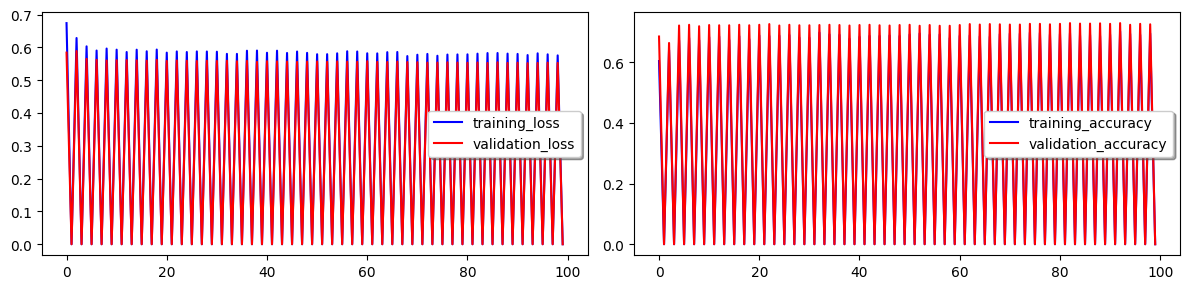

In [15]:
display_history(history)

In [16]:
results = model.evaluate(valid_set)

print('Test loss: {:4f}'.format(results[0]))
print('Test accuracy: {:4f}'.format(results[1]))

40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7038 - loss: 0.5669
Test loss: 0.551367
Test accuracy: 0.724763


21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step
              precision    recall  f1-score   support

     Control       0.74      0.68      0.71       347
    Dementia       0.67      0.73      0.70       305

    accuracy                           0.70       652
   macro avg       0.70      0.70      0.70       652
weighted avg       0.71      0.70      0.70       652



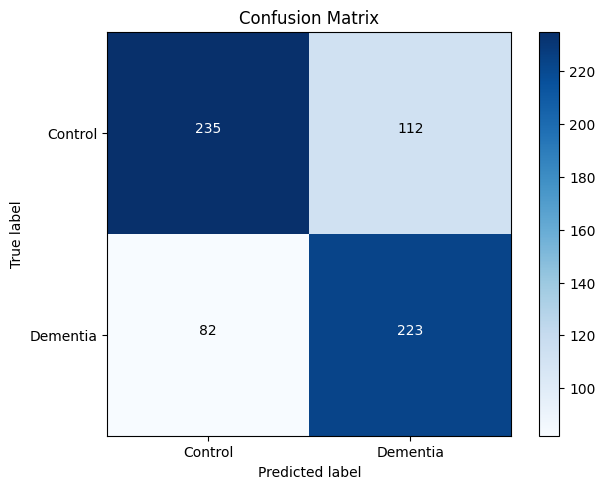

In [17]:
pred = model.predict(test_set, steps=TEST_STEPS)
y_pred = np.argmax(pred, axis=1)
y_true = test_set.classes

print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
display_confusion_matrix(cm=cm, classes=CLASSES, title='Confusion Matrix')

In [18]:
batch = iter(test_set)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


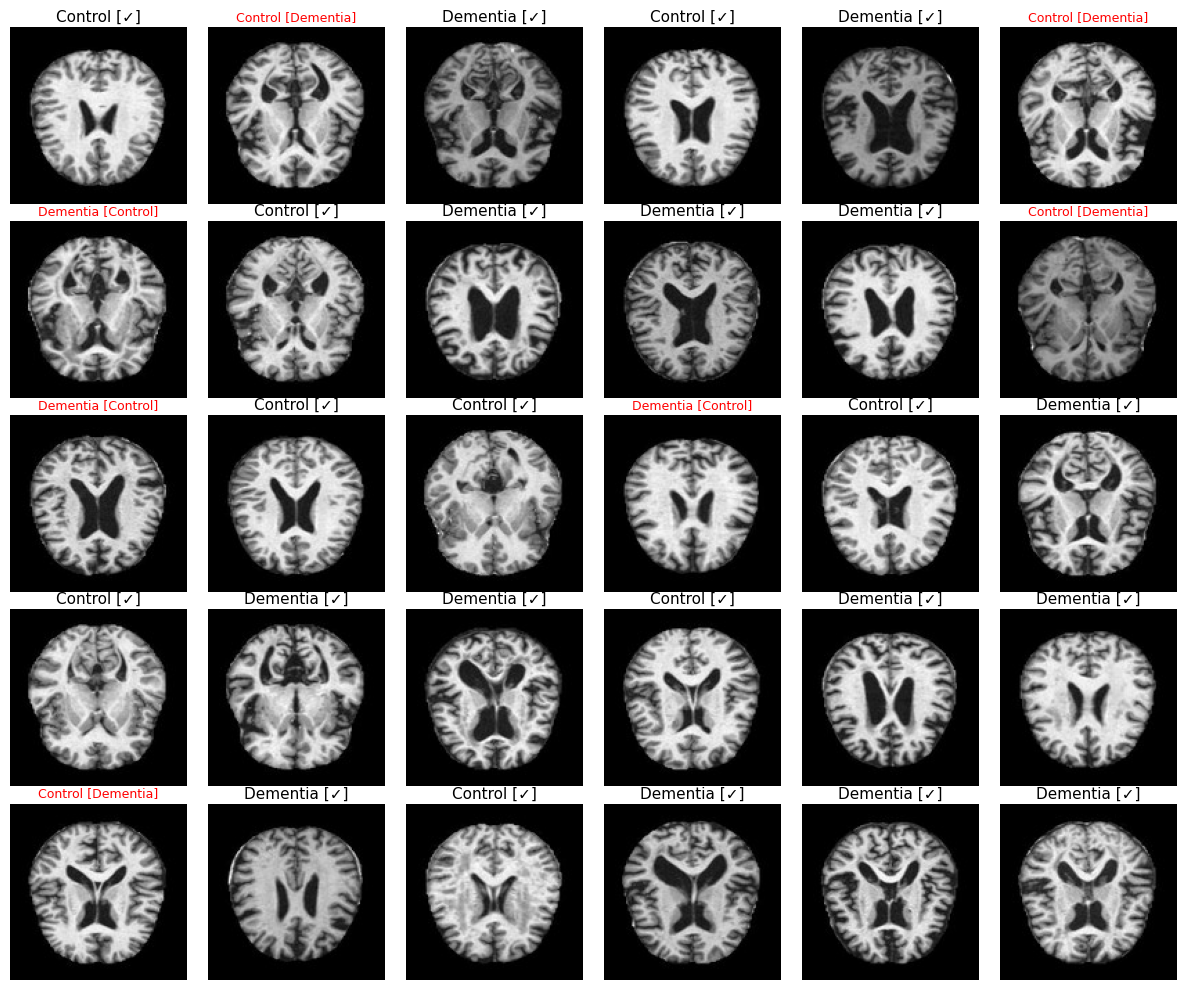

In [19]:
images, labels = next(batch)
predictions = np.argmax(model.predict(images), axis=-1)
display_batch((images, labels), predictions)